Example modified from:

https://github.com/ritvikmath/Time-Series-Analysis/tree/master

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [142]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [143]:
#read data
catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0],  date_parser=parser)
#catfish_sales.set_index('Date', inplace=True)
catfish_sales.head()

C:\Users\salmank\AppData\Local\Temp\ipykernel_22000\3874338730.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('data/catfish.csv', parse_dates=[0],  date_parser=parser)


,Date,Total
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


In [144]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[(catfish_sales['Date'] >= start_date) & (catfish_sales['Date'] < end_date)]
lim_catfish_sales.head()

,Date,Total
168,2000-01-01,25412
169,2000-02-01,25354
170,2000-03-01,29161
171,2000-04-01,24924
172,2000-05-01,24763


<Figure size 1000x400 with 0 Axes>

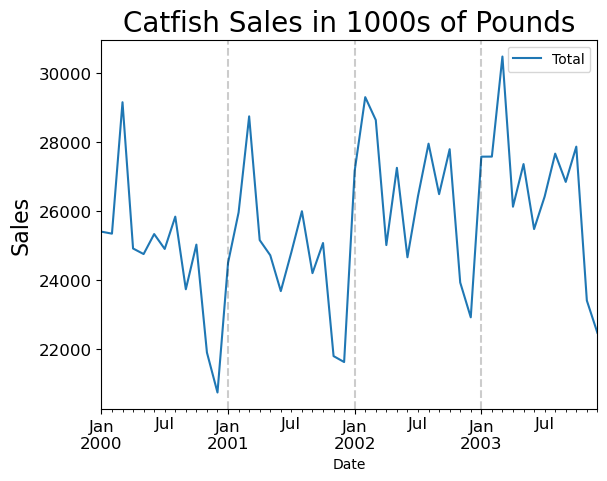

In [145]:
plt.figure(figsize=(10,4))
lim_catfish_sales.plot(x='Date', y='Total', fontsize=12)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)

for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)



In [146]:
first_diff = lim_catfish_sales.copy()
first_diff['Total'] = first_diff['Total'].diff()
first_diff.dropna(inplace=True)
first_diff.head()

,Date,Total
169,2000-02-01,-58.0
170,2000-03-01,3807.0
171,2000-04-01,-4237.0
172,2000-05-01,-161.0
173,2000-06-01,579.0


<Figure size 1000x400 with 0 Axes>

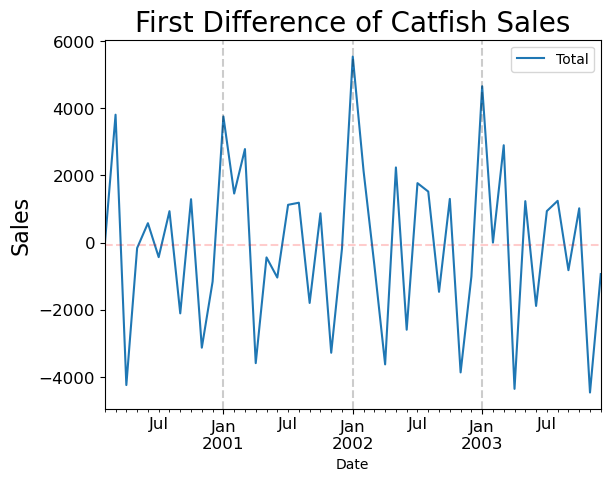

In [147]:
plt.figure(figsize=(10,4))
first_diff.plot(x='Date', y='Total', fontsize=12)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff['Total'].mean(), color='r', alpha=0.2, linestyle='--')

# ACF

<BarContainer object of 21 artists>

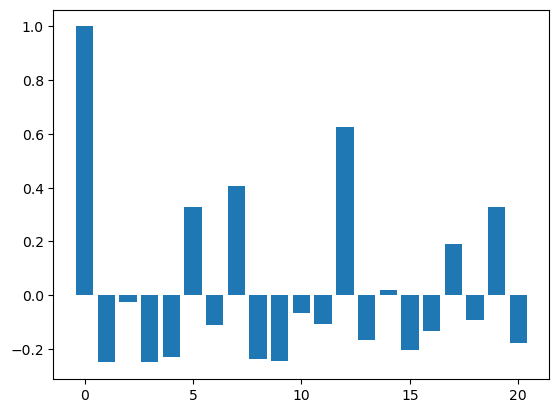

In [149]:
num_lags =20
acf_vals = acf(first_diff['Total'], nlags=num_lags)

plt.bar(range(len(acf_vals)), acf_vals)

## Based on ACF, we should start with a MA(1) process

# PACF

<BarContainer object of 17 artists>

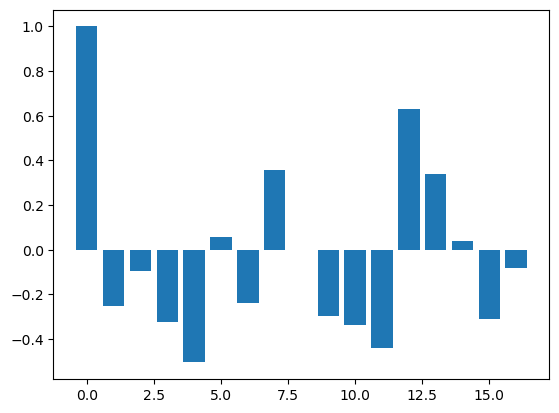

In [150]:
pacf_vals = pacf(first_diff['Total'])
plt.bar(range(len(pacf_vals)), pacf_vals)

## Based on PACF, we should start with a AR(4) process

# Get training and testing sets

In [178]:
first_diff.reset_index(drop=True, inplace=True)

In [181]:
train_end = int(0.6*len(first_diff))

train_data = first_diff['Total'][:train_end]
test_data = first_diff['Total'][train_end:]

# Fit the ARMA Model

In [184]:
# define model
model = ARIMA(train_data, order=(4,0,1))

In [185]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.10345673561096191


In [186]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   28
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -250.850
Date:                Sun, 07 Apr 2024   AIC                            515.701
Time:                        23:18:45   BIC                            525.026
Sample:                             0   HQIC                           518.551
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.0357    274.406      0.241      0.810    -471.790     603.861
ar.L1         -0.9430      0.262     -3.596      0.000      -1.457      -0.429
ar.L2         -0.5317      0.424     -1.255      0.2

## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [187]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [188]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

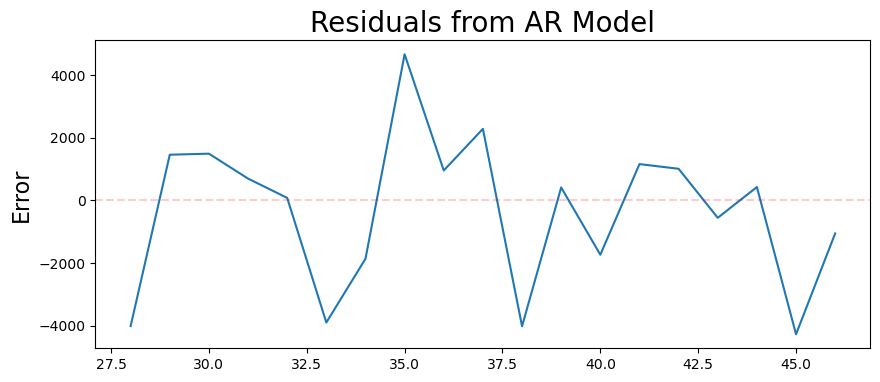

In [189]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

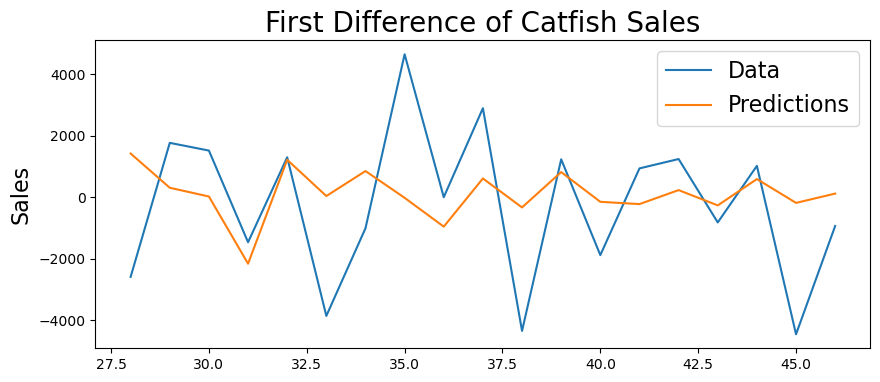

In [190]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [163]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2406.9832027714547
